In [40]:
# Download dataset
import os
from kaggle.api.kaggle_api_extended import KaggleApi

print("  Downloading dataset...")
api = KaggleApi()
api.authenticate()
api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='./data', unzip=True)
print("  Dataset downloaded!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
  Dataset downloaded!


In [60]:
"""
MediScan-AI: Day 3 - Model Architecture & Training Setup
========================================================
Goal: Build ResNet50 baseline and train on Fold 1
"""

# ============================================================================
# PART 1: IMPORTS & SETUP
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import json
import os
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#  MODIFIED DEVICE CONFIGURATION FOR M2:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(" Using M2 GPU!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

 Using M2 GPU!
Device: mps


In [53]:
# ============================================================================
# PART 2: LOAD PREPROCESSING CONFIG
# ============================================================================

# Check if config files exist
config_path = 'outputs/preprocessing_config.json'
weights_path = 'outputs/class_weights.json'

if os.path.exists(config_path) and os.path.exists(weights_path):
    # Load the preprocessing config from Day 2
    with open(config_path, 'r') as f:
        config = json.load(f)

    with open(weights_path, 'r') as f:
        class_weights_data = json.load(f)

    print(" Loaded Day 2 Configuration")
    print(f"   Training samples: {config['data_info']['train_size']}")
    print(f"   Test samples: {config['data_info']['test_size']}")
    print(f"   Class weights: Normal={class_weights_data['normal_weight']:.4f}, "
          f"Pneumonia={class_weights_data['pneumonia_weight']:.4f}")
else:
    print("  Day 2 config files not found - using default values")
    # Fallback to default values
    config = {
        'data_info': {
            'train_size': 5216,
            'test_size': 624
        },
        'augmentation': {
            'rotation_degrees': 15,
            'horizontal_flip_prob': 0.5,
            'translate': [0.1, 0.1],
            'scale': [0.9, 1.1],
            'brightness': 0.2,
            'contrast': 0.2
        },
        'kfold': {
            'n_folds': 5,
            'shuffle': True,
            'random_state': 42
        },
        'training': {
            'batch_size': 32,
            'num_workers': 4,
            'pin_memory': True
        }
    }
    
    class_weights_data = {
        'normal_weight': 1.9448,
        'pneumonia_weight': 0.6730
    }
    
    print(" Using default configuration")

 Loaded Day 2 Configuration
   Training samples: 5216
   Test samples: 624
   Class weights: Normal=1.9448, Pneumonia=0.6730


In [54]:
# ============================================================================
# PART 3: DATA TRANSFORMS
# ============================================================================

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(config['augmentation']['rotation_degrees']),
    transforms.RandomHorizontalFlip(p=config['augmentation']['horizontal_flip_prob']),
    transforms.RandomAffine(
        degrees=0,
        translate=tuple(config['augmentation']['translate']),
        scale=tuple(config['augmentation']['scale'])
    ),
    transforms.ColorJitter(
        brightness=config['augmentation']['brightness'],
        contrast=config['augmentation']['contrast']
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print(" Transforms defined")


 Transforms defined


In [55]:
# ============================================================================
# PART 4: RESNET50 MODEL ARCHITECTURE
# ============================================================================

class PneumoniaResNet(nn.Module):
    """
    ResNet50-based pneumonia classifier
    - Uses pre-trained ResNet50 as feature extractor
    - Freezes early layers, fine-tunes later layers
    - Custom classifier head for binary classification
    """
    
    def __init__(self, num_classes=2, freeze_layers=True):
        super(PneumoniaResNet, self).__init__()
        
        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze early layers if specified
        if freeze_layers:
            # Freeze all layers initially
            for param in self.resnet.parameters():
                param.requires_grad = False
            
            # Unfreeze last residual block (layer4) for fine-tuning
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        
        # Custom classifier head with dropout for regularization
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)
    
    def unfreeze_all(self):
        """Unfreeze all layers for full fine-tuning"""
        for param in self.resnet.parameters():
            param.requires_grad = True

# Initialize model
model = PneumoniaResNet(num_classes=2, freeze_layers=True)
model = model.to(device)

print(" ResNet50 Model Created")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


 ResNet50 Model Created
   Total parameters: 24,558,146
   Trainable parameters: 16,014,850


In [56]:
# ============================================================================
# PART 5: LOSS FUNCTION & OPTIMIZER
# ============================================================================

# Class weights for handling imbalance
class_weights = torch.tensor([
    class_weights_data['normal_weight'],
    class_weights_data['pneumonia_weight']
], dtype=torch.float32).to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer - Adam with weight decay for regularization
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001,
    weight_decay=1e-4
)

# Learning rate scheduler - reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    #verbose=True
)

print("  Training Setup Complete")
print(f"   Loss: CrossEntropyLoss with class weights")
print(f"   Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau")


  Training Setup Complete
   Loss: CrossEntropyLoss with class weights
   Optimizer: Adam (lr=0.001, weight_decay=1e-4)
   Scheduler: ReduceLROnPlateau


In [57]:
# ============================================================================
# PART 6: TRAINING & VALIDATION FUNCTIONS
# ============================================================================

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch
    
    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
        all_labels: True labels
        all_predictions: Predicted labels
        all_probs: Prediction probabilities
    """
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []
    
    progress_bar = tqdm(dataloader, desc='Validation', leave=False)
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Get predictions and probabilities
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = running_loss / len(all_labels)
    accuracy = 100 * accuracy_score(all_labels, all_predictions)
    
    return avg_loss, accuracy, all_labels, all_predictions, all_probs


In [58]:
# ============================================================================
# PART 7: METRICS CALCULATION
# ============================================================================

def calculate_metrics(y_true, y_pred, class_names=['NORMAL', 'PNEUMONIA']):
    """
    Calculate comprehensive metrics
    
    Returns:
        metrics_dict: Dictionary containing all metrics
    """
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Macro averages
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    metrics_dict = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'per_class': {
            class_names[i]: {
                'precision': precision[i],
                'recall': recall[i],
                'f1': f1[i]
            }
            for i in range(len(class_names))
        }
    }
    
    return metrics_dict


def plot_confusion_matrix(y_true, y_pred, class_names=['NORMAL', 'PNEUMONIA'], 
                         title='Confusion Matrix', save_path=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.7, f'({cm_norm[i, j]*100:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_learning_curves(history, save_path=None):
    """Plot training and validation learning curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print(" Training & Evaluation Functions Ready")


 Training & Evaluation Functions Ready


In [61]:
# ============================================================================
# PART 8: LOAD DATASET & SETUP FOLD 1
# ============================================================================

# Load full training dataset
train_dataset = ImageFolder('data/chest_xray/train', transform=train_transform)
val_dataset = ImageFolder('data/chest_xray/train', transform=val_transform)

print(f" Dataset loaded: {len(train_dataset)} samples")

# Setup K-Fold Cross Validation (use Fold 1 on Day 3)
kfold = KFold(n_splits=config['kfold']['n_folds'], 
              shuffle=config['kfold']['shuffle'], 
              random_state=config['kfold']['random_state'])

# Get Fold 1 indices
fold_idx = 0
all_indices = list(range(len(train_dataset)))
train_indices, val_indices = list(kfold.split(all_indices))[fold_idx]

print(f"   Fold 1 Setup:")
print(f"   Training samples: {len(train_indices)}")
print(f"   Validation samples: {len(val_indices)}")

# Create data loaders for Fold 1
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['training']['batch_size'],
    sampler=train_sampler,
    num_workers=config['training']['num_workers'],
    pin_memory=config['training']['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['training']['batch_size'],
    sampler=val_sampler,
    num_workers=config['training']['num_workers'],
    pin_memory=config['training']['pin_memory']
)

print(f"   DataLoaders Created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

 Dataset loaded: 5216 samples
   Fold 1 Setup:
   Training samples: 4172
   Validation samples: 1044
   DataLoaders Created
   Train batches: 131
   Val batches: 33


In [62]:
# ============================================================================
# PART 9: TRAINING LOOP - FOLD 1
# ============================================================================

# Training configuration
NUM_EPOCHS = 15
FOLD_NAME = "fold_1"

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0

print("=" * 70)
print(f" STARTING TRAINING - FOLD 1 (Baseline Model)")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Device: {device}")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Training phase
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase
    val_loss, val_acc, val_labels, val_preds, val_probs = validate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        
        # Save model checkpoint
        os.makedirs('models', exist_ok=True)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, f'models/resnet50_{FOLD_NAME}_best.pth')
        
        print(f" Best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "=" * 70)
print(" TRAINING COMPLETE!")
print(f"   Best Epoch: {best_epoch}")
print(f"   Best Val Loss: {best_val_loss:.4f}")
print(f"   Best Val Acc: {best_val_acc:.2f}%")
print("=" * 70)


 STARTING TRAINING - FOLD 1 (Baseline Model)
   Epochs: 15
   Device: mps

Epoch 1/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.1874 | Train Acc: 93.29%
Val Loss:   0.0901 | Val Acc:   96.55%
 Best model saved! (Val Loss: 0.0901)

Epoch 2/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.1226 | Train Acc: 95.06%
Val Loss:   0.0774 | Val Acc:   96.84%
 Best model saved! (Val Loss: 0.0774)

Epoch 3/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0887 | Train Acc: 96.98%
Val Loss:   0.1221 | Val Acc:   93.20%

Epoch 4/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0991 | Train Acc: 96.57%
Val Loss:   0.0807 | Val Acc:   96.65%

Epoch 5/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.1025 | Train Acc: 96.02%
Val Loss:   0.0703 | Val Acc:   96.65%
 Best model saved! (Val Loss: 0.0703)

Epoch 6/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:03<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0860 | Train Acc: 97.08%
Val Loss:   0.0937 | Val Acc:   95.69%

Epoch 7/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0790 | Train Acc: 96.91%
Val Loss:   0.0784 | Val Acc:   96.46%

Epoch 8/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0789 | Train Acc: 97.36%
Val Loss:   0.0642 | Val Acc:   97.70%
 Best model saved! (Val Loss: 0.0642)

Epoch 9/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0762 | Train Acc: 97.20%
Val Loss:   0.0622 | Val Acc:   97.13%
 Best model saved! (Val Loss: 0.0622)

Epoch 10/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0670 | Train Acc: 97.56%
Val Loss:   0.1078 | Val Acc:   95.11%

Epoch 11/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0668 | Train Acc: 97.34%
Val Loss:   0.0643 | Val Acc:   97.13%

Epoch 12/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0688 | Train Acc: 97.65%
Val Loss:   0.1080 | Val Acc:   94.25%

Epoch 13/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0700 | Train Acc: 97.63%
Val Loss:   0.0562 | Val Acc:   97.22%
 Best model saved! (Val Loss: 0.0562)

Epoch 14/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0601 | Train Acc: 97.75%
Val Loss:   0.1415 | Val Acc:   92.82%

Epoch 15/15
--------------------------------------------------


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training:   0%|          | 0/131 [00:02<?, ?it/s]

Validation:   0%|          | 0/33 [00:02<?, ?it/s]

Train Loss: 0.0719 | Train Acc: 97.51%
Val Loss:   0.0632 | Val Acc:   97.41%

 TRAINING COMPLETE!
   Best Epoch: 13
   Best Val Loss: 0.0562
   Best Val Acc: 97.22%



 Generating Evaluation Metrics...


/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation:   0%|          | 0/33 [00:02<?, ?it/s]


 FOLD 1 BASELINE RESULTS:
--------------------------------------------------
Accuracy:  97.22%
Precision: 95.74%
Recall:    97.54%
F1-Score:  96.58%

Per-Class Metrics:
  NORMAL:
    Precision: 92.16%
    Recall:    98.26%
    F1-Score:  95.11%
  PNEUMONIA:
    Precision: 99.32%
    Recall:    96.83%
    F1-Score:  98.06%

 Plotting Learning Curves...


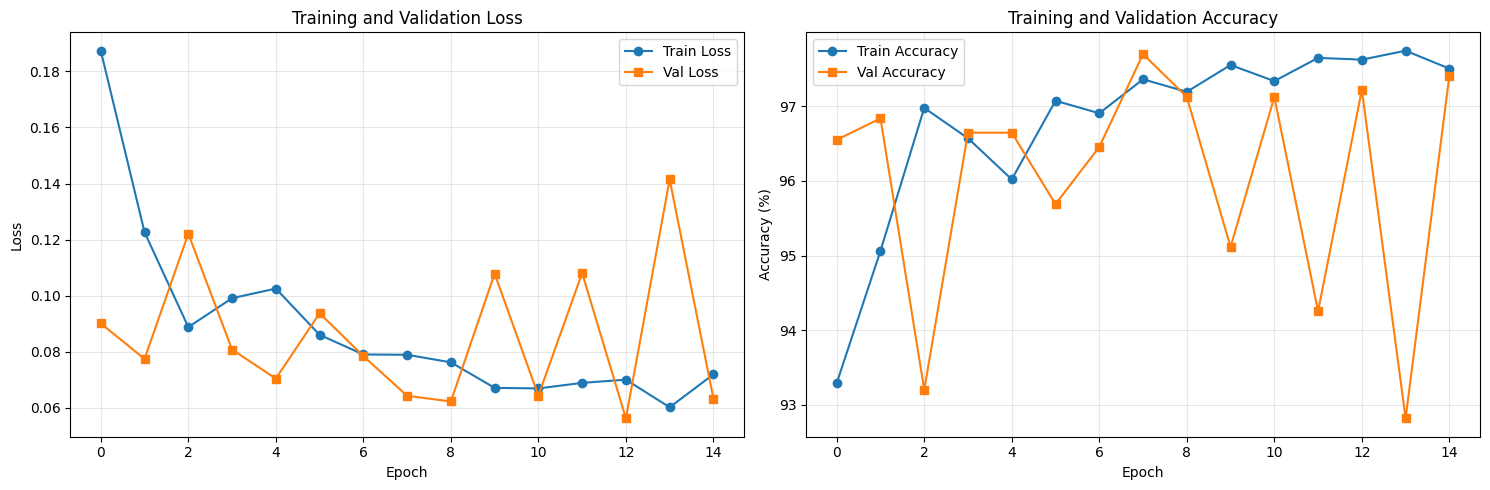


 Plotting Confusion Matrix...


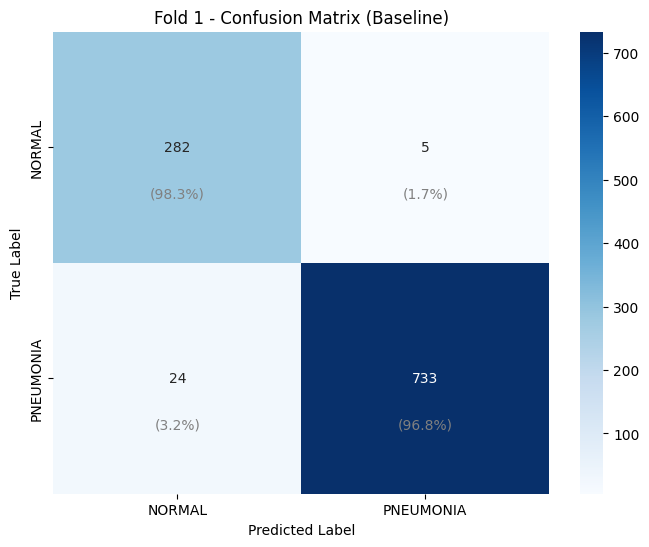


 Evaluation complete! Results saved to outputs/


In [63]:
# ============================================================================
# PART 10: EVALUATION & VISUALIZATION
# ============================================================================

print("\n Generating Evaluation Metrics...")

# Load best model
checkpoint = torch.load(f'models/resnet50_{FOLD_NAME}_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final validation
val_loss, val_acc, val_labels, val_preds, val_probs = validate(
    model, val_loader, criterion, device
)

# Calculate comprehensive metrics
metrics = calculate_metrics(val_labels, val_preds)

print("\n FOLD 1 BASELINE RESULTS:")
print("-" * 50)
print(f"Accuracy:  {metrics['accuracy']*100:.2f}%")
print(f"Precision: {metrics['precision_macro']*100:.2f}%")
print(f"Recall:    {metrics['recall_macro']*100:.2f}%")
print(f"F1-Score:  {metrics['f1_macro']*100:.2f}%")
print("\nPer-Class Metrics:")
for class_name, class_metrics in metrics['per_class'].items():
    print(f"  {class_name}:")
    print(f"    Precision: {class_metrics['precision']*100:.2f}%")
    print(f"    Recall:    {class_metrics['recall']*100:.2f}%")
    print(f"    F1-Score:  {class_metrics['f1']*100:.2f}%")

# Plot learning curves
print("\n Plotting Learning Curves...")
os.makedirs('outputs', exist_ok=True)
plot_learning_curves(history, save_path='outputs/fold1_learning_curves.png')

# Plot confusion matrix
print("\n Plotting Confusion Matrix...")
plot_confusion_matrix(
    val_labels, val_preds,
    title='Fold 1 - Confusion Matrix (Baseline)',
    save_path='outputs/fold1_confusion_matrix.png'
)

# Save metrics to JSON
metrics_output = {
    'fold': 1,
    'model': 'ResNet50',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training': {
        'epochs': NUM_EPOCHS,
        'best_epoch': best_epoch,
        'batch_size': config['training']['batch_size']
    },
    'metrics': metrics,
    'history': history
}

with open('outputs/fold1_baseline_metrics.json', 'w') as f:
    json.dump(metrics_output, f, indent=4)

print("\n Evaluation complete! Results saved to outputs/")


In [64]:
# ============================================================================
# PART 11: CLASSIFICATION REPORT
# ============================================================================

print("\n" + "=" * 70)
print("CLASSIFICATION REPORT - FOLD 1 BASELINE")
print("=" * 70)
print(classification_report(
    val_labels, val_preds,
    target_names=['NORMAL', 'PNEUMONIA'],
    digits=4
))


CLASSIFICATION REPORT - FOLD 1 BASELINE
              precision    recall  f1-score   support

      NORMAL     0.9216    0.9826    0.9511       287
   PNEUMONIA     0.9932    0.9683    0.9806       757

    accuracy                         0.9722      1044
   macro avg     0.9574    0.9754    0.9658      1044
weighted avg     0.9735    0.9722    0.9725      1044



In [67]:
# DAY 3 SUMMARY
# ============================================================================

summary = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                   DAY 3 SUMMARY - BASELINE MODEL                     ║
╚══════════════════════════════════════════════════════════════════════╝

 COMPLETED TASKS:
   • ResNet50 architecture built with custom head
   • Training pipeline implemented with class weights
   • Learning rate scheduling configured
   • Fold 1 trained for {NUM_EPOCHS} epochs
   • Comprehensive metrics calculated
   • Visualizations generated

 BASELINE RESULTS (Fold 1):
   • Validation Accuracy: {metrics['accuracy']*100:.2f}%
   • Precision (macro):    {metrics['precision_macro']*100:.2f}%
   • Recall (macro):       {metrics['recall_macro']*100:.2f}%
   • F1-Score (macro):     {metrics['f1_macro']*100:.2f}%
   • Best Epoch:           {best_epoch}/{NUM_EPOCHS}

 PER-CLASS PERFORMANCE:
   NORMAL:
   • Precision: {metrics['per_class']['NORMAL']['precision']*100:.2f}%
   • Recall:    {metrics['per_class']['NORMAL']['recall']*100:.2f}%
   • F1-Score:  {metrics['per_class']['NORMAL']['f1']*100:.2f}%
   
   PNEUMONIA:
   • Precision: {metrics['per_class']['PNEUMONIA']['precision']*100:.2f}%
   • Recall:    {metrics['per_class']['PNEUMONIA']['recall']*100:.2f}%
   • F1-Score:  {metrics['per_class']['PNEUMONIA']['f1']*100:.2f}%

 SAVED ARTIFACTS:
   ✓ models/resnet50_fold_1_best.pth
   ✓ outputs/fold1_learning_curves.png
   ✓ outputs/fold1_confusion_matrix.png
   ✓ outputs/fold1_baseline_metrics.json

 SUCCESS CRITERIA CHECK:
   {'✅' if metrics['accuracy'] > 0.75 else '❌'} Validation accuracy > 75%
   {'✅' if best_val_loss < history['train_loss'][0] else '❌'} Training/val losses decreased
    Model trains without errors
    Not predicting single class


 Day 3 Complete - Ready for Cross-Validation!
"""

print(summary)

# Save summary
with open('outputs/day3_summary.txt', 'w') as f:
    f.write(summary)

print(" Summary saved to outputs/day3_summary.txt")


╔══════════════════════════════════════════════════════════════════════╗
║                   DAY 3 SUMMARY - BASELINE MODEL                     ║
╚══════════════════════════════════════════════════════════════════════╝

 COMPLETED TASKS:
   • ResNet50 architecture built with custom head
   • Training pipeline implemented with class weights
   • Learning rate scheduling configured
   • Fold 1 trained for 15 epochs
   • Comprehensive metrics calculated
   • Visualizations generated

 BASELINE RESULTS (Fold 1):
   • Validation Accuracy: 97.22%
   • Precision (macro):    95.74%
   • Recall (macro):       97.54%
   • F1-Score (macro):     96.58%
   • Best Epoch:           13/15

 PER-CLASS PERFORMANCE:
   NORMAL:
   • Precision: 92.16%
   • Recall:    98.26%
   • F1-Score:  95.11%
   
   PNEUMONIA:
   • Precision: 99.32%
   • Recall:    96.83%
   • F1-Score:  98.06%

 SAVED ARTIFACTS:
   ✓ models/resnet50_fold_1_best.pth
   ✓ outputs/fold1_learning_curves.png
   ✓ outputs/fold1_confusion_m